# **PRACTICA 2**

In [74]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import random
import time
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# **0. KMEAN PERSONALIZADO**

En el siguiente código se implementa y compara el algoritmo de k-means personalizado con la implementación de k-means de la biblioteca scikit-learn, utilizando un conjunto de datos sintéticos. A continuación, describo detalladamente cada parte del código:

### Creación de datos de ejemplo
- num_samples: Número de muestras en el conjunto de datos.
- num_features: Número de características (dimensiones) de cada muestra.
- num_clusters: Número de clústeres que se desea identificar en el conjunto de datos.
- make_blobs: Esta función de scikit-learn genera un conjunto de datos distribuidos en 'blobs' o agrupaciones. Los parámetros definen la cantidad de muestras, centros (clústeres), desviación estándar de cada clúster y una semilla para la generación aleatoria, asegurando la reproducibilidad.

### Asignación de clústeres
- assign_clusters(data, centroids): Calcula la distancia entre cada punto del conjunto de datos y los centroides, y asigna cada punto al clúster del centroide más cercano.

### Actualización de centroides
- update_centroids(data, labels, k): Actualiza los centroides para que sean el promedio de todos los puntos que han sido asignados a cada clúster.

### Función k-means principal
- kmeans(data, k, num_iterations=10000, tolerance=1e-4): Esta función ejecuta el algoritmo k-means personalizado, iterando hasta que los centroides no cambian significativamente (menos que tolerance) o se alcanza el número máximo de iteraciones:
- Inicializa los centroides.
- Itera asignando clústeres y actualizando centroides.
- Comprueba la convergencia en cada iteración.

### Comparación de rendimiento y calidad del clúster
El código mide el tiempo de ejecución y calcula el puntaje de silueta para ambos métodos, k-means personalizado y scikit-learn. El puntaje de silueta mide qué tan bien se agrupan los puntos dentro de los clústeres y qué tan separados están los clústeres entre sí.

### Visualización
Utiliza matplotlib para visualizar los resultados de ambos métodos, mostrando los puntos de datos, los centroides y diferenciando los clústeres por color.

Comparación entre k-means personalizado y scikit-learn:
Tiempo de ejecución (personalizado): 0.016112327575683594 segundos
Silhouette score (personalizado): 0.4516975629687692
Tiempo de ejecución (scikit-learn): 0.01386880874633789 segundos
Silhouette score (scikit-learn): 0.4501781592911625


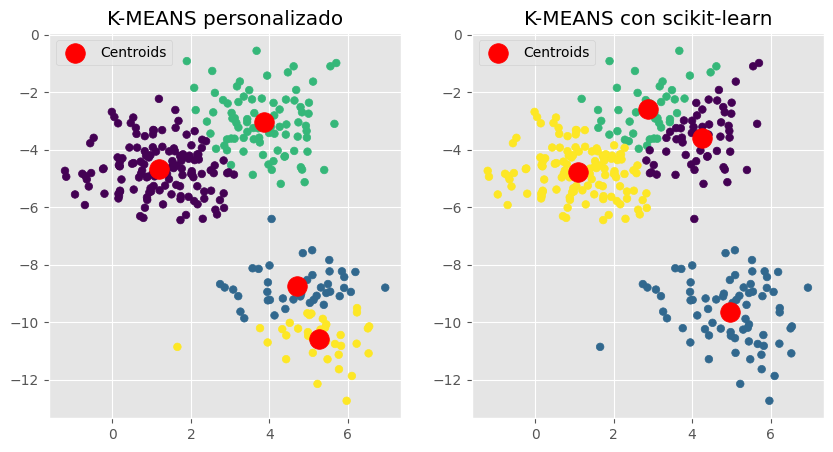

In [104]:
# Crear datos de ejemplo
num_samples = 300
num_features = 2
num_clusters = 4

data, _ = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=1.0, random_state=100472097)

# Elegir centros iniciales aleatorios
def initialize_centroids(data, k):
    # Escoger el primer centroide al azar
    centroids = [data[random.randint(0, len(data) - 1)]]

    # Escoger el resto de los centroides usando el método K-Means++
    for _ in range(1, k):
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(range(len(data)), p=probabilities)
        centroids.append(data[new_centroid_index])

    return np.array(centroids)

# Asignar puntos a los clústeres
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Actualizar los centros de los clústeres
def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# Función para el algoritmo k-means
def kmeans(data, k, num_iterations=10000, tolerance=1e-4):

    centroids = initialize_centroids(data, k)

    for _ in range(num_iterations):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # Chequeo de convergencia
        if np.linalg.norm(centroids - new_centroids) < tolerance:
            break

        centroids = new_centroids

    return centroids, labels


#Comparación entre k-means personalizado y scikit-learn
start_time = time.time()
centroids_custom, labels_custom = kmeans(data, num_clusters)
custom_time = time.time() - start_time
silhouette_custom = silhouette_score(data, labels_custom)

start_time = time.time()
sklearn_kmeans = SKLearnKMeans(n_clusters=num_clusters, random_state=100472097).fit(data)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
sklearn_time = time.time() - start_time
silhouette_sklearn = silhouette_score(data, labels_sklearn)

# Mostrar resultados
print("Comparación entre k-means personalizado y scikit-learn:")
print("Tiempo de ejecución (personalizado):", custom_time, "segundos")
print("Silhouette score (personalizado):", silhouette_custom)

print("Tiempo de ejecución (scikit-learn):", sklearn_time, "segundos")
print("Silhouette score (scikit-learn):", silhouette_sklearn)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("K-MEANS personalizado")
plt.scatter(data[:, 0], data[:, 1], c=labels_custom, cmap='viridis', s=30)
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], c='red', s=200, label='Centroids')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("K-MEANS con scikit-learn")
plt.scatter(data[:, 0], data[:, 1], c=labels_sklearn, cmap='viridis', s=30)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], c='red', s=200, label='Centroids')
plt.legend()


plt.show()

# EMPEZAMOS CON LA PREPARACIÓN DE DATOS

Lo primero que vamos a hacer es cargar los datos:

In [105]:
df = pd.read_csv('stars_data.csv')

Observamos los datos que tenemos en nuestro dataset:

In [106]:
# Crear un dataframe de ejemplo
unique_colors = df['Color'].unique()
unique_spectral_classes = df['Spectral_Class'].unique()

print("Clases únicas para 'color':", unique_colors)
print("Clases únicas para 'Spectral_class':", unique_spectral_classes)
# Definir columnas categóricas
categorical_columns = ['color', 'Spectral_Class']

# Valores de ejemplo para OrdinalEncoder
df.head()

Clases únicas para 'color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Clases únicas para 'Spectral_class': ['M' 'B' 'A' 'F' 'O' 'K' 'G']


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Observamos que hay datos que pueden identificarse de varias formas, entonces debemos agrupar dichos dichas variables categoricas, hacemos el mapping:

In [107]:
# Obtenemos toda la serie de colores que existe en el dataset
df.Color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

In [108]:
# Establecemos una unificación de colores:
mapping_colors = {
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

In [109]:
# Mapeamos los datos
for target_color, source_colors in mapping_colors.items():
  df.loc[df.Color.isin(source_colors), 'Color'] = target_color
df

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


Comprobamos que los datos están unificados:

In [110]:
# Comprobamos que los valores están unificados.
df.Color.unique()

array(['Red', 'Blue-White', 'White', 'White-Yellow', 'Yellow-Orange',
       'Blue', 'Orange', 'Yellow', 'Orange-Red'], dtype=object)

In [111]:
# Obtenemos los colores ordenados (directamente del mapping!)
colors = list(mapping_colors.keys())
colors

['Red',
 'Orange-Red',
 'Orange',
 'Yellow-Orange',
 'Yellow',
 'White-Yellow',
 'White',
 'Blue-White',
 'Blue']

# **1. ENCODING**

Defino las 'Spectral Class' que existen, o sea establezco sus valores:

In [114]:
spectral_class = ['O','B','A','F','G','K','M']

### 1.1 OneHot

In [119]:
# Crear el dataframe con One-Hot Encoding
df_one_hot = pd.get_dummies(df.copy(), columns=['Color', 'Spectral_Class'])

# Convertir las columnas booleanas a valores 0 y 1
df_one_hot = df_one_hot.astype(int)

print("DataFrame con One-Hot Encoding usando 0 y 1:")
df_one_hot.head()

DataFrame con One-Hot Encoding usando 0 y 1:


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Red,Color_White,Color_White-Yellow,Color_Yellow,Color_Yellow-Orange,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


### 1.2 Ordinal

In [118]:
from sklearn.preprocessing import OrdinalEncoder

# Crear un OrdinalEncoder con orden específico
ordinal_encoder = OrdinalEncoder(categories=[colors, spectral_class])

# Aplicar OrdinalEncoder a las columnas categóricas
df_ordinal = df.copy()
df_ordinal[['Color', 'Spectral_Class']] = ordinal_encoder.fit_transform(df[['Color', 'Spectral_Class']])

# Mostrar el DataFrame con valores ordinales
print("DataFrame con columnas categóricas convertidas a ordinalidad:")
df_ordinal.head(10)

DataFrame con columnas categóricas convertidas a ordinalidad:


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,6.0
1,3042,0.000500,0.1542,16.60,0.0,6.0
2,2600,0.000300,0.1020,18.70,0.0,6.0
3,2800,0.000200,0.1600,16.65,0.0,6.0
4,1939,0.000138,0.1030,20.06,0.0,6.0
5,2840,0.000650,0.1100,16.98,0.0,6.0
6,2637,0.000730,0.1270,17.22,0.0,6.0
7,2600,0.000400,0.0960,17.40,0.0,6.0
8,2650,0.000690,0.1100,17.45,0.0,6.0
9,2700,0.000180,0.1300,16.05,0.0,6.0


In [121]:
# One-Hot Encoding para "color"
df_ohec_os = pd.get_dummies(df, columns=['Color'])

ordinal_encoder = OrdinalEncoder(categories=[spectral_class])
# Ordinalidad para "Spectral_class"
df_ohec_os['Spectral_Class'] = ordinal_encoder.fit_transform(df[['Spectral_Class']])

# Convertir booleanos a ceros y unos
df_mixed_2 = df_ohec_os.astype(int)

print("DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:")
df_mixed_2.head()

DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:


,Temperature,L,R,A_M,Spectral_Class,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Red,Color_White,Color_White-Yellow,Color_Yellow,Color_Yellow-Orange
0,3068,0,0,16,6,0,0,0,0,1,0,0,0,0
1,3042,0,0,16,6,0,0,0,0,1,0,0,0,0
2,2600,0,0,18,6,0,0,0,0,1,0,0,0,0
3,2800,0,0,16,6,0,0,0,0,1,0,0,0,0
4,1939,0,0,20,6,0,0,0,0,1,0,0,0,0


In [122]:
# Ordinalidad para "color"
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[colors])

df_oc_ohes = df.copy()
df_oc_ohes['Color'] = ordinal_encoder.fit_transform(df[['Color']])

# One-Hot Encoding para "Spectral_class"
df_oc_ohes = pd.get_dummies(df_oc_ohes, columns=['Spectral_Class'])

# Convertir booleanos a ceros y unos
df_oc_ohes = df_oc_ohes.astype(int)

print("DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:")
df_oc_ohes.head()

DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:


,Temperature,L,R,A_M,Color,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,0,1,0


# **2. SCALING**

### 2.1 Con escalador

### 2.2 Sin escalador

# **3. REDUCCIÓN DE DIMENSIONES**

### 3.1 None

### 3.2 PCA

In [123]:
import pandas as pd
from sklearn.decomposition import PCA

# Supongamos que ya tienes df_mixed_1 y df_mixed_2 después de las transformaciones anteriores

# Aplicar PCA con 2 componentes
pca = PCA(n_components=2)

# Aplicar PCA al primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
df_mixed_1_pca = pca.fit_transform(df_oc_ohes)

# Convertir el resultado a DataFrame para visualización
df_mixed_1_pca_df = pd.DataFrame(df_mixed_1_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el primer DataFrame:")
print(df_mixed_1_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_mixed_2_pca = pca.fit_transform(df_ohec_os)

# Convertir el resultado a DataFrame para visualización
df_mixed_2_pca_df = pd.DataFrame(df_mixed_2_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el segundo DataFrame:")
print(df_mixed_2_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_ordinal_pca = pca.fit_transform(df_ordinal)

# Convertir el resultado a DataFrame para visualización
df_ordinal_pca_df = pd.DataFrame(df_ordinal_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el tercer DataFrame:")
print(df_ordinal_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_one_hot_pca = pca.fit_transform(df_one_hot)

# Convertir el resultado a DataFrame para visualización
df_one_hot_pca_df = pd.DataFrame(df_one_hot_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el cuarto DataFrame:")
print(df_one_hot_pca_df.head())

Resultados de PCA para el primer DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895116     -5177.122958
1   -107321.440836     -5203.116133
2   -107330.718148     -5645.000469
3   -107326.520227     -5445.052609
4   -107344.592099     -6305.827319
Resultados de PCA para el segundo DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.921006     -5177.121793
1   -107321.468668     -5203.114876
2   -107330.746268     -5644.998791
3   -107326.548353     -5445.051420
4   -107344.620358     -6305.825578
Resultados de PCA para el tercer DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.921025     -5177.122469
1   -107321.468688     -5203.115551
2   -107330.746287     -5644.999445
3   -107326.548372     -5445.052083
4   -107344.620377     -6305.826203
Resultados de PCA para el cuarto DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895097     -5177.122282
1   -107321.440817     -5203.115458
2   -107330.718129     -5644.999815
3   -107326.520207     -5445.05

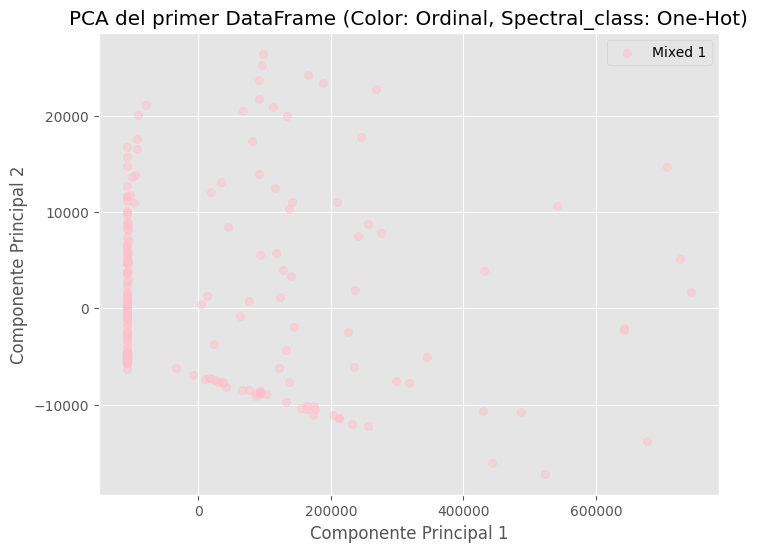

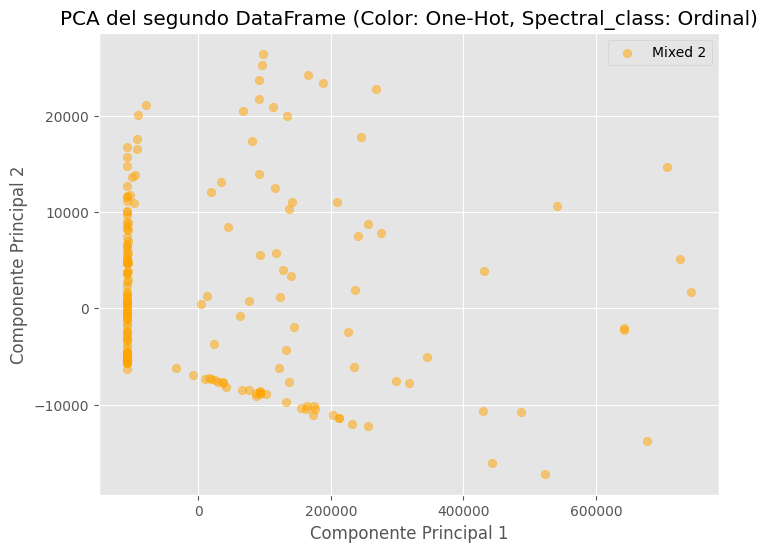

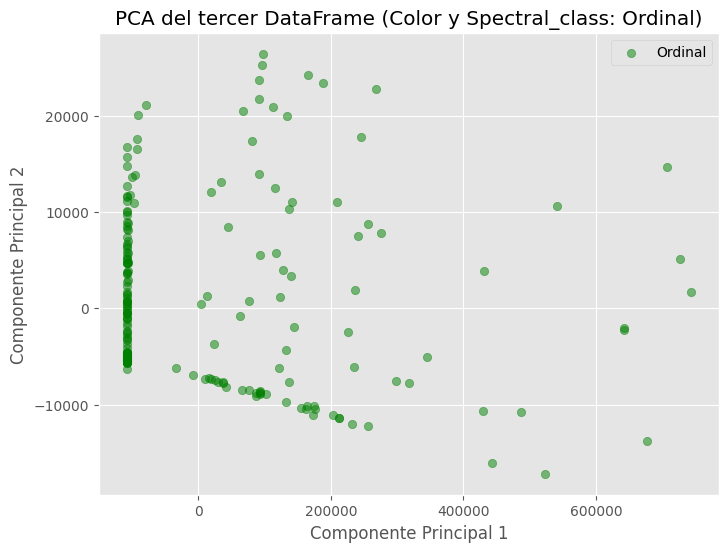

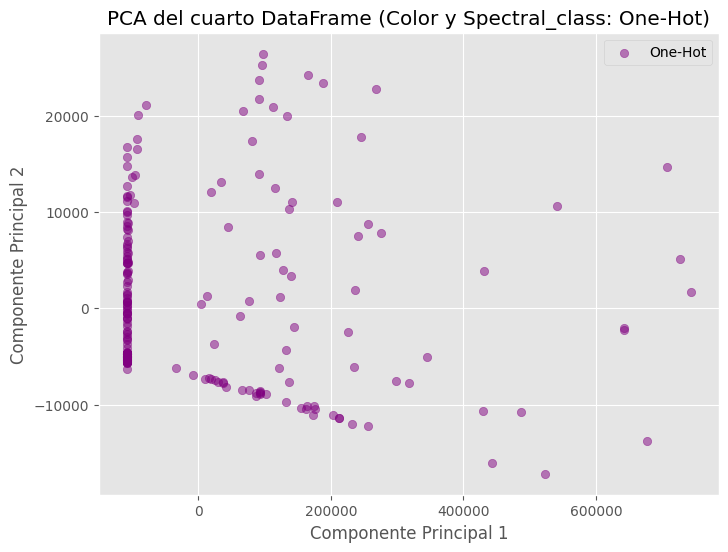

In [126]:
import matplotlib.pyplot as plt

# Gráfico para el primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_1_pca_df["PCA_Component_1"], df_mixed_1_pca_df["PCA_Component_2"], c='pink', alpha=0.5, label='Mixed 1')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del primer DataFrame (Color: Ordinal, Spectral_class: One-Hot)")
plt.legend()
plt.show()

# Gráfico para el segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_2_pca_df["PCA_Component_1"], df_mixed_2_pca_df["PCA_Component_2"], c='orange', alpha=0.5, label='Mixed 2')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del segundo DataFrame (Color: One-Hot, Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el tercer DataFrame (color y Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_ordinal_pca_df["PCA_Component_1"], df_ordinal_pca_df["PCA_Component_2"], c='green', alpha=0.5, label='Ordinal')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del tercer DataFrame (Color y Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el cuarto DataFrame (color y Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_one_hot_pca_df["PCA_Component_1"], df_one_hot_pca_df["PCA_Component_2"], c='purple', alpha=0.5, label='One-Hot')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del cuarto DataFrame (Color y Spectral_class: One-Hot)")
plt.legend()
plt.show()

# **4. CLUSTERING**

### 4.1 KMeans

### 4.2 Hierarchical/DBScan

## **DETERMINACIÓN DE TIPOS DE ESTRELLAS**

 1. Programar k-means, utilizando buenas prácticas de programación, es decir, debe ser una función y comparar los resultados y la eficiencia con la implementación de k-means en scikit-learn

2. Tenemos variables categóricas (Color, Clase Espectral). Tenemos dos
posibilidades: (a) codificar con one-hot-encoding; (b) codificar como una variable
ordinal. Tener en cuenta que el color está asociado a la cantidad de energía, y
algo parecido con la clase espectral.

3. Aplicar al menos dos diferentes algoritmos de clustering de los explicados en clase (K-Means, Hierarchical Clustering/Dendrogramas, DBSCAN), comparando y discutiendo los resultados que se obtienen de ellos

4. Discutir los resultados que se obtienen si a los atributos categóricos se les aplica one-hot-encoding o se asigna un valor numérico a las secuencias (variable ordinal).


5. A partir de los resultados obtenidos, ¿qué pipeline de clustering, es decir, qué transformaciones de datos, algoritmo, con sus hiperparámetros, transformación de datos y análisis de resultados recomendaría realizar?

6. ¿Hay similitudes con los grupos obtenidos en el punto 4? Explicar